## Cargo el modelo

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def objectness_accuracy(y_true, y_pred):
    obj_true = y_true[..., 0]
    obj_pred = y_pred[..., 0]
    return tf.keras.metrics.binary_accuracy(obj_true, obj_pred)

def positive_objectness_error(y_true, y_pred):
    # Extraemos objectness ground truth y predicción
    obj_true = y_true[..., 0]
    obj_pred = y_pred[..., 0]

    # Filtramos solo donde el ground truth es positivo (1)
    mask = tf.equal(obj_true, 1.0)

    # Predicciones en esas posiciones (sin binarizar, puede ser entre 0 y 1)
    preds_pos = tf.boolean_mask(obj_pred, mask)

    # Error absoluto promedio en los positivos (puede cambiarse por otra métrica)
    error = tf.reduce_mean(tf.abs(1.0 - preds_pos))

    return error

In [ ]:
def detection_loss(y_true, y_pred):
    obj_true = y_true[..., 0]  # shape: (batch, 28, 28)
    obj_pred = y_pred[..., 0]

    bbox_true = y_true[..., 1:]  # shape: (batch, 28, 28, 4)
    bbox_pred = y_pred[..., 1:]

    # Calculamos la pérdida por pixel, asegurando que mantenga la forma [batch, 28, 28]
    bce = tf.keras.backend.binary_crossentropy(obj_true, obj_pred)
    bce = tf.reshape(bce, tf.shape(obj_true))  # ahora sí, obj_true es [batch, 28, 28]

    # Pérdida de bounding boxes solo donde hay objetos
    mask = tf.expand_dims(obj_true, axis=-1)
    bbox_loss = tf.reduce_sum(mask * tf.square(bbox_true - bbox_pred), axis=-1)

    # Sumamos las dos pérdidas
    total_loss = bce + bbox_loss
    return tf.reduce_mean(total_loss)

In [ ]:
def build_model():
    inputs = tf.keras.Input(shape=(None, None, 1))  # imágenes de cualquier tamaño

    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(2)(x)  # x/2

    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)  # x/4

    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)  # x/8

    output = tf.keras.layers.Conv2D(5, 1, padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs, output)

In [ ]:
from tensorflow.keras.models import load_model
import gradio as gr

model = build_model()

# Cargás solo los pesos
model.load_weights("/content/drive/MyDrive/tp_integrador/deteccion.keras")  # Sí, también podés usar .keras como fuente de pesos

# Recompilás si es necesario
model.compile(optimizer="adam", loss=detection_loss, metrics=[positive_objectness_error])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


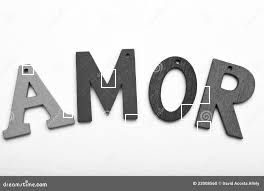

In [ ]:
#Cargar imagen en escala de grises (o color si así fue entrenado)
img_path = '/content/AMOR.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_norm = img.astype('float32') / 255.0

# 3. Preprocesar para red
input_tensor = np.expand_dims(img_norm, axis=(0, -1))  # [1, H, W, 1]

# 4. Predecir
y_pred = model.predict(input_tensor)[0]  # [H', W', 5] sin batch

# 5. Dibujar cajas si objectness > umbral
h_cells, w_cells = y_pred.shape[:2]
img_h, img_w = img.shape
stride_y = img_h / h_cells
stride_x = img_w / w_cells

threshold = 0.5

for i in range(h_cells):
    for j in range(w_cells):
        objectness = y_pred[i, j, 0]
        if objectness > threshold:
            # Valores relativos
            xc_rel, yc_rel, w_rel, h_rel = y_pred[i, j, 1:]

            # Celda origen
            cell_x = j * stride_x
            cell_y = i * stride_y

            # Posición absoluta
            xc = cell_x + xc_rel * stride_x
            yc = cell_y + yc_rel * stride_y
            bw = w_rel * img_w
            bh = h_rel * img_h

            x1 = int(xc - bw / 2)
            y1 = int(yc - bh / 2)
            x2 = int(xc + bw / 2)
            y2 = int(yc + bh / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 1)

# 6. Mostrar resultado
cv2_imshow(img)

## Interface con gradio

In [ ]:
# 🧠 Función para predecir y dibujar los bounding boxes
def detectar_caracteres(img):
    # Convertir a escala de grises si es necesario
    if img.mode != 'L':
        img = img.convert('L')

    img_arr = np.array(img).astype(np.float32) / 255.0  # Normalizar
    h, w = img_arr.shape
    input_tensor = img_arr[None, ..., None]  # Shape: (1, alto, ancho, 1)

    # 📈 Predecir con el modelo
    pred = model.predict(input_tensor)[0]  # Shape: (grid_h, grid_w, 5)
    grid_h, grid_w, _ = pred.shape

    # 📦 Interpretar la salida
    threshold = 0.8
    bboxes = []
    for i in range(grid_h):
        for j in range(grid_w):
            objectness = pred[i, j, 0]
            if objectness > threshold:
                x_rel, y_rel, w_rel, h_rel = pred[i, j, 1:]

                # Coordenadas relativas dentro de la celda → coordenadas absolutas en la imagen original
                cx = (j + x_rel) / grid_w * w
                cy = (i + y_rel) / grid_h * h
                bw = w_rel * w
                bh = h_rel * h

                x1 = int(cx - bw / 2)
                y1 = int(cy - bh / 2)
                x2 = int(cx + bw / 2)
                y2 = int(cy + bh / 2)
                bboxes.append((x1, y1, x2, y2))

    # 🖼 Dibujar cajas sobre la imagen original
    img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2BGR)
    for x1, y1, x2, y2 in bboxes:
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 1)

    return Image.fromarray(img_bgr)

# 🚀 Interfaz Gradio
gr.Interface(
    fn=detectar_caracteres,
    inputs=gr.Image(type="pil", label="Subí una imagen (escala de grises o color)"),
    outputs=gr.Image(label="Imagen con detecciones"),
    title="Detección de caracteres",
    description="Este modelo detecta caracteres (sin clasificarlos) y dibuja los bounding boxes."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4473ad9e9593b27ee8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
